# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# Modified: now tensorflow.keras instead of just keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Data Collection and Organization

### Note: Some price series are not available on non-business days, hence there will be an issue with NaNs. 
### Ideally, we should drop all weekends and holidays 

In [2]:
#Loading the data
VIX_raw = pd.read_csv('data/VIX.csv', header = 2)
DOW_raw = pd.read_csv('data/DOW.csv', header = 2)
GFD_raw = pd.read_csv('data/GFD_TBILL_DAILY.csv', header = 2)
GOLD_raw = pd.read_csv('data/GOLD.csv', header = 2)
SPX_raw = pd.read_csv('data/SPX.csv', header = 2)
# I'm not using US_10YR because it contains duplicate values for many dates
#US_10YR = pd.read_csv('data/US_10yr_yield.csv', header = 2)

In [3]:
# Define a helper function to process the data
def process_data(df, label, feature_engineering = True):
    
    # Convert the Date column from a string to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Get only the Dates earlier than 2021-10-21 since we aren't predicting into the future
    df = df.loc[(df['Date'] <= '2021-10-21')]
    
    # Carries forward old prices, so we aren't using future information
    df.fillna(method = 'ffill', inplace=True) 
    
    # Drop the 'Ticker' and 'Open' columns
    df = df.drop(columns = ['Ticker', 'Open'], axis=1)
    
    # Take percentage changes
    if feature_engineering == True:
        
        # Grab percentage changes in price
        percentage_changes = df.loc[:, 'Close'].pct_change()
        
        # Daily percentage change feature
        df[label+"_pct_change"] = percentage_changes
        
        # Rolling volatility feature
        long_term_vol = percentage_changes.std()
        rolling_vol_30_day = percentage_changes.rolling(window=30).std() / long_term_vol
        rolling_vol_10_day = percentage_changes.rolling(window=10).std() / long_term_vol
        df[label+"_rolling_vol_30D"] = rolling_vol_30_day
        df[label+"_rolling_vol_10D"] = rolling_vol_10_day
        
    else:
        # Just label the closing price column with passed label
        df[label] = df.loc[:,'Close']
    
    # Reverse the data to go backward in time
    df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)
    
    # Rename the 'Close' column with the passed label
    #df = df.rename(columns={'Close': label})
    df = df.drop(columns = 'Close')
    
    return df

# Process all of the data
VIX = process_data(VIX_raw, 'VIX', feature_engineering = False) # We predict raw VIX levels.
DOW = process_data(DOW_raw, 'DOW')
GFD = process_data(GFD_raw, 'TBILL')
GOLD = process_data(GOLD_raw, 'GOLD')
SPX = process_data(SPX_raw, 'SPX')
#US_10YR = process_data(US_10YR, 'US_10YR')


# Merge all of the data into one large dataframe
from functools import reduce

dfs = [VIX, DOW, GFD, GOLD, SPX]
#dfs = [VIX, DOW, GFD, GOLD, SPX, US_10YR]
data = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dfs)

# Sort the data by descending date
data = data.sort_values(by='Date', ascending=False).reset_index(drop=True)

# Absent values should have percentage changes of zero. 
# But we want to front-fill the VIX volumn
data.loc[:, 'VIX'] = data.loc[:,'VIX'].fillna(method='bfill') # Use old VIX values to fill nans in the future.

# Everything remaining we can just fill with zero.
data = data.fillna(value = 0.0)

# Drop days with no price change (Either a weekend or a holiday)
data = data.loc[np.abs(data.SPX_pct_change) > 0.000000]

# Data Visualization

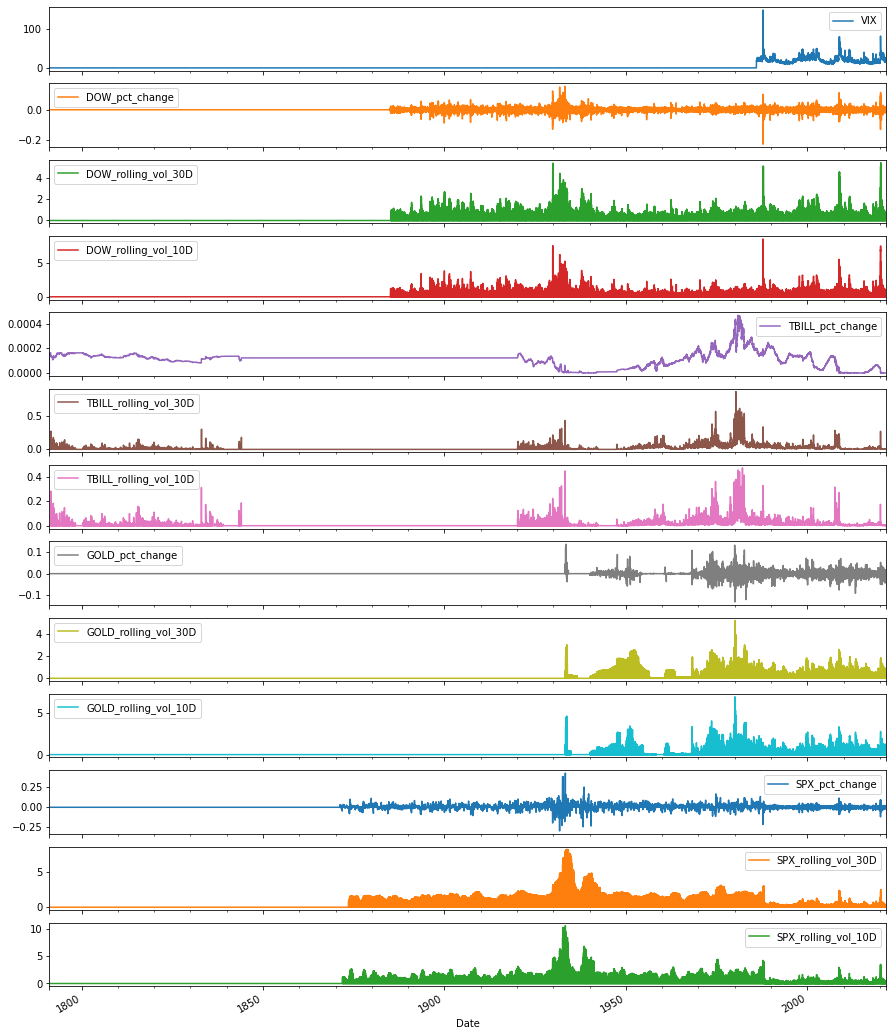

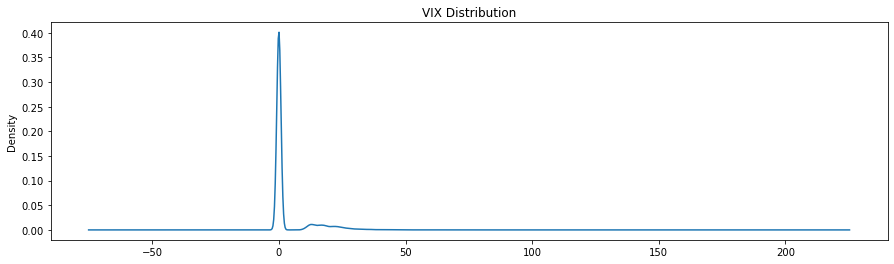

In [14]:
data.plot('Date', subplots=True, figsize = (15,20))
plt.show()

data['VIX'].plot(kind = 'kde', figsize = (15,4), title = 'VIX Distribution')
plt.show()

# Data Processing

In [4]:
def lstm_data_processing(data, start_date, end_date, n_time_steps = 90, include_vix = True):

    # Get the indices of the start date and the end date
    start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
    end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    
    # Flag to set if VIX data is included in the training set
    if include_vix:
        # Get all of the input data (X)
        X_data = data[:,1:].astype('float32')
    else:
        # Get all of the input data (X)
        X_data = data[:,2:].astype('float32')   
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], n_time_steps, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data

# Define a function to process the data for Bidirectional LSTM
def bidirectional_data_processing(data, start_date, end_date, n_time_steps = 30):

    # Get the indices of the start date and the end date
    start_index = int(np.where(data[:,0] == pd.to_datetime(start_date))[0])
    end_index = int(np.where(data[:,0] == pd.to_datetime(end_date))[0])
    
    # Get all of the input data (X)
    X_data = data[:,2:].astype('float32')
    
    # Create an empty array to store the restructured input data
    X_data_extended = np.zeros((X_data.shape[0], 2*n_time_steps+1, X_data.shape[-1]))

    # Loop through all samples 
    for i in range(start_index, end_index+1):
        X_data_extended[i] = X_data[i-n_time_steps:i+n_time_steps+1,:]
    
    # Get all of the input data (X) for the desired date range
    X_data = X_data_extended[start_index:end_index+1]

    # Get all of the output data (Y) for the desired date range
    y_data = data[start_index:end_index+1,1].astype('float32')
    
    return X_data, y_data

# Convert the data from a pandas dataframe to a numpy array
np_data = data.to_numpy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = np_data.copy()
scaled_data[:,1:] = scaler.fit_transform(scaled_data[:,1:])

# Define the number of timesteps to look forward and backward (total number of timesteps is 2*n_timesteps+1)
n_time_steps = 30

# Split data into train, dev, and test sets
X_train, y_train = lstm_data_processing(scaled_data, start_date = '12/31/2020', end_date = '01/01/1991', n_time_steps = n_time_steps, include_vix = False)
X_dev, y_dev = lstm_data_processing(scaled_data, start_date = '12/31/1990', end_date = '07/01/1988', n_time_steps = n_time_steps, include_vix = False)
X_test, y_test = lstm_data_processing(scaled_data, start_date = '06/30/1988', end_date = '01/01/1986', n_time_steps = n_time_steps, include_vix = False)

# Verify the shapes of the input and output data
print(X_train.shape)
print(y_train.shape)
print(X_dev.shape)
print(y_dev.shape)
print(X_test.shape)
print(y_test.shape)

(10958, 30, 12)
(10958,)
(914, 30, 12)
(914,)
(912, 30, 12)
(912,)


# Basic LSTM Model

In [ ]:
# Building the model
lstm_model = Sequential()

# Adding a LSTM layer
lstm_model.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, input_shape=(X_train.shape[1], X_train.shape[-1])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
# Training the model
lstm = lstm_model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_dev, y_dev))

In [ ]:
lstm_model.summary()

In [ ]:
# plot training and dev losses over epoch
plt.plot(lstm.history['loss'], label='train')
plt.plot(lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### Basic LSTM Model Prediction and Visualization

In [ ]:
# make predictions for the training and dev sets
y_train_hat = lstm_model.predict(X_train)
y_dev_hat = lstm_model.predict(X_dev)

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_train_hat, color='red', label='Predicted')
axs.plot(y_train, color='blue', label='Actual')
plt.title('Training Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()

fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_dev_hat, color='red', label='Predicted')
axs.plot(y_dev, color='blue', label='Actual')
plt.title('Dev Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()

# Bi-LSTM

### Without hyperparameter tuning:

In [ ]:
bi_lstm_model = Sequential()
bi_lstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[-1])))
bi_lstm_model.add(Bidirectional(LSTM(64)))
bi_lstm_model.add(Dense(1))
bi_lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
# Training the model
bi_lstm = bi_lstm_model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_dev, y_dev))

In [ ]:
bi_lstm_model.summary()

In [ ]:
# plot training and dev losses over epoch
plt.plot(bi_lstm.history['loss'], label='train')
plt.plot(bi_lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### With hyperparameter tuning:

In [5]:
import keras_tuner as kt

In [6]:
# Keras-Tuner helper method, used for tuning
def build_bi_lstm_model(hp):
    bi_lstm_model = Sequential()
    
    # initialize i in case the number of layers is only 1:
    i = 0
    
    # Tune the number of layers
    for i in range(1, hp.Int("num_layers", 1, 3)):
        # Bidirectional LSTM layer i
        bi_lstm_model.add(Bidirectional(LSTM(
            units=hp.Choice(f'units_{i}', [16,32,64,128]),
            return_sequences=True, 
            dropout=hp.Float(f"dropout_{i}", min_value=0.0, max_value=0.5, step = 0.05),
            recurrent_dropout=hp.Float(f"recurrent_dropout_{i}", min_value=0.0, max_value=0.5, step = 0.1))))
    
    # Last Bidirectional LSTM layer
    bi_lstm_model.add(Bidirectional(LSTM(
        units=hp.Choice(f'units_{i+1}', [16,32,64,128]),
        return_sequences=False, 
        dropout=hp.Float(f"dropout_{i+1}", min_value=0.0, max_value=0.5, step = 0.05),
        recurrent_dropout=hp.Float(f"recurrent_dropout_{i+1}", min_value=0.0, max_value=0.5, step = 0.1))))
    
    # Fully-connected layer with output 1
    bi_lstm_model.add(Dense(1))
    
    # Tune the learning rate
    opt = Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log"))
    
    bi_lstm_model.compile(loss='mse', optimizer=opt)
    return bi_lstm_model

In [17]:
# This will read in hyperparameters from the last time that the RandomSearch was performed, 
# if the untitlied_project folder is in the current directory
tuner = kt.RandomSearch(
    build_bi_lstm_model,
    objective='val_loss',
    max_trials= 300,
    directory = 'Hyperparameter_Tuning')

INFO:tensorflow:Reloading Oracle from existing project Hyperparameter_Tuning\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from Hyperparameter_Tuning\untitled_project\tuner0.json


In [18]:
# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=50, validation_data=(X_dev, y_dev),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 103 Complete [00h 08m 26s]
val_loss: 0.0003445845504757017

Best val_loss So Far: 0.00031725066946819425
Total elapsed time: 07h 46m 01s

Search: Running Trial #104

Hyperparameter    |Value             |Best Value So Far 
num_layers        |1                 |2                 
units_1           |128               |16                
dropout_1         |0.1               |0                 
recurrent_dropo...|0.3               |0.4               
lr                |0.005588          |0.00039646        
units_2           |16                |64                
dropout_2         |0.45              |0.45              
recurrent_dropo...|0.4               |0.2               
units_3           |128               |128               
dropout_3         |0.05              |0.2               
recurrent_dropo...|0.3               |0.2               

Epoch 1/50


KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

In [10]:
# Retrieve best model (model with the best hyperparameters)
best_model = tuner.get_best_models()[0]

# Fit this model to the training data
best_bi_lstm = best_model.fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_dev, y_dev),
                             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/25
86/86 [==============================] - 42s 423ms/step - loss: 5.8653e-04 - val_loss: 3.5233e-04
Epoch 2/25
86/86 [==============================] - 30s 348ms/step - loss: 5.6369e-04 - val_loss: 4.3857e-04
Epoch 3/25
86/86 [==============================] - 29s 338ms/step - loss: 5.6301e-04 - val_loss: 3.6263e-04
Epoch 4/25
86/86 [==============================] - 29s 336ms/step - loss: 5.5743e-04 - val_loss: 3.7878e-04
Epoch 5/25
86/86 [==============================] - 29s 337ms/step - loss: 5.5795e-04 - val_loss: 4.4104e-04
Epoch 6/25
86/86 [==============================] - 29s 340ms/step - loss: 5.3966e-04 - val_loss: 3.7291e-04


In [11]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 256)           144384    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                73984     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 218,433
Trainable params: 218,433
Non-trainable params: 0
_________________________________________________________________


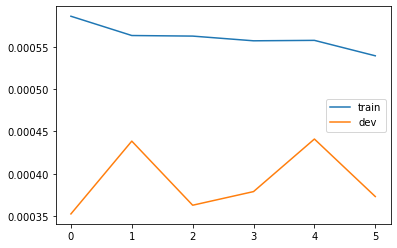

In [12]:
# plot training and dev losses over epoch
plt.plot(best_bi_lstm.history['loss'], label='train')
plt.plot(best_bi_lstm.history['val_loss'], label='dev')
plt.legend()
plt.show()

### Bi-LSTM Model Prediction and Visualization

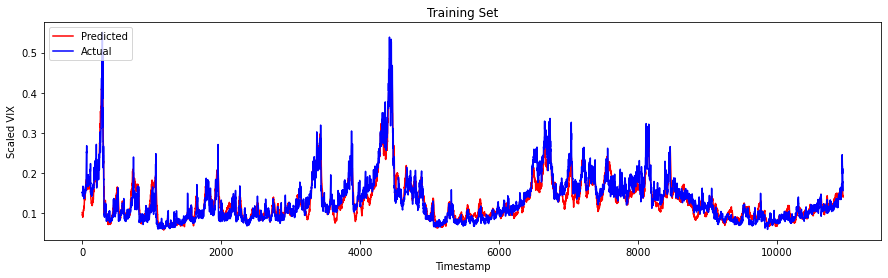

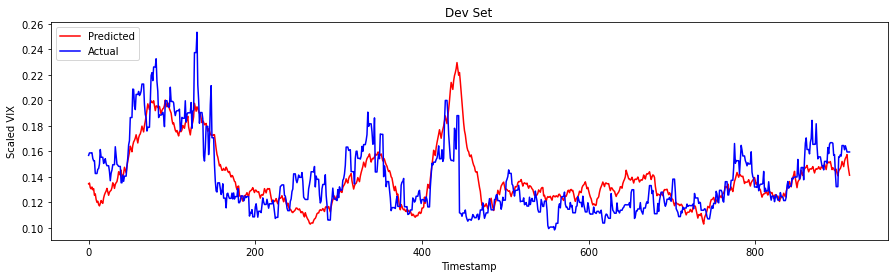

In [13]:
# make predictions for the training and dev sets
y_train_hat = best_model.predict(X_train)
y_dev_hat = best_model.predict(X_dev)

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_train_hat, color='red', label='Predicted')
axs.plot(y_train, color='blue', label='Actual')
plt.title('Training Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()

fig, axs = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(15)

axs.plot(y_dev_hat, color='red', label='Predicted')
axs.plot(y_dev, color='blue', label='Actual')
plt.title('Dev Set')
plt.xlabel('Timestamp')
plt.ylabel('Scaled VIX')
plt.legend(loc='upper left')
plt.show()

## Experimenting with Loss Functions

In [ ]:
from tensorflow.math import reduce_mean, pow

def m4e(y_true, y_pred):
    return reduce_mean(pow(y_true - y_pred, 4), axis=-1)

def m8e(y_true, y_pred):
    return reduce_mean(pow(y_true - y_pred, 8), axis=-1)

In [ ]:
def build_bi_lstm_model_loss(loss='mse'):
    bi_lstm_model = Sequential()
    
    # Bidirectional LSTM layer 1
    bi_lstm_model.add(Bidirectional(LSTM(
        units=32,
        return_sequences=True, 
        dropout=0.0,
        recurrent_dropout=0.2,
        input_shape=(X_train.shape[1], X_train.shape[-1]))))
    
    # Bidirectional LSTM layer 2
    bi_lstm_model.add(Bidirectional(LSTM(
        units=32,
        return_sequences=False, 
        dropout=0.45,
        recurrent_dropout=0.3)))
    
    # Fully-connected layer with output 1
    bi_lstm_model.add(Dense(1))
    
    # Tune the learning rate
    opt = Adam(learning_rate=0.005)
    
    # Define the loss function based on the passed argument
    if loss == 'm4e':
        bi_lstm_model.compile(loss=m4e, optimizer=opt)
    elif loss == 'm8e':
        bi_lstm_model.compile(loss=m8e, optimizer=opt)
    else:
        bi_lstm_model.compile(loss=loss, optimizer=opt)
        
    return bi_lstm_model

bi_lstm_mae_model = build_bi_lstm_model_loss(loss='mae')
bi_lstm_logcosh_model = build_bi_lstm_model_loss(loss='logcosh')
bi_lstm_mse_model = build_bi_lstm_model_loss(loss='mse')
bi_lstm_m4e_model = build_bi_lstm_model_loss(loss='m4e')
bi_lstm_m8e_model = build_bi_lstm_model_loss(loss='m8e')

loss_models = [[bi_lstm_mae_model, 'Mean Absolute Error'],
               [bi_lstm_logcosh_model, 'Log-Cosh Error'],
               [bi_lstm_mse_model, 'Mean Squared Error'], 
               [bi_lstm_m4e_model, 'Mean ^4 Error'],
               [bi_lstm_m8e_model, 'Mean ^8 Error']]

In [ ]:
# Fit the models to the training data
for model in loss_models:
    print(model[1] + ":")
    model[0].fit(X_train, y_train, batch_size=128, epochs=25, validation_data=(X_dev, y_dev))

In [ ]:
for model in loss_models:
    # make predictions for the training and dev sets
    y_train_hat = model[0].predict(X_train)
    y_dev_hat = model[0].predict(X_dev)

    # Showing the predicted vs. actual values
    fig, axs = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(15)
    
    fig.suptitle(model[1], fontsize=16)
    
    axs.plot(y_train_hat, color='red', label='Predicted')
    axs.plot(y_train, color='blue', label='Actual')
    plt.title('Training Set')
    plt.xlabel('Timestamp')
    plt.ylabel('Scaled VIX')
    plt.legend(loc='upper left')
    plt.show()

    fig, axs = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(15)

    axs.plot(y_dev_hat, color='red', label='Predicted')
    axs.plot(y_dev, color='blue', label='Actual')
    plt.title('Dev Set')
    plt.xlabel('Timestamp')
    plt.ylabel('Scaled VIX')
    plt.legend(loc='upper left')
    plt.show()